In [1]:
# https://media.readthedocs.org/pdf/face-recognition/latest/face-recognition.pdf
# https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78
import face_recognition
import cv2
import numpy as np
import glob
import os
import logging
import pickle

In [2]:
# adapted from the Deep Learning: Face Recognition course from LinkedIn Learning

IMAGES_PATH = './intranet_images'  # put your reference images in here
#IMAGES_PATH = './images'    # put your reference images in here
CAMERA_DEVICE_ID = 0
MAX_DISTANCE = 0.6  # increase to make recognition less strict, decrease to make more strict

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output/brim.avi', fourcc, 7.0, (640, 480))


In [3]:
def get_face_embeddings_from_image(image, convert_to_rgb=False):
    """
    Take a raw image and run both the face detection and face embedding model on it
    """
    # Convert from BGR to RGB if needed
    if convert_to_rgb:
        image = image[:, :, ::-1]

    # run the face detection model to find face locations
    face_locations = face_recognition.face_locations(image)
#     print(face_locations)

    # run the embedding model to get face embeddings for the supplied locations
    face_encodings = face_recognition.face_encodings(image, face_locations)

    return face_locations, face_encodings

In [4]:
def load_database_from_file():
    db_file_name = 'database.file'
    with open(db_file_name, 'rb') as fp:
        database = pickle.load(fp)

    return database

In [5]:
def setup_database():
    """
    Load reference images and create a database of their face encodings
    """
    database = {}
    count = 0
    print(os.path.join(IMAGES_PATH, '*.jpg'))
    for filename in glob.glob(os.path.join(IMAGES_PATH, '*.jpg')):
        # load image
        print(filename)
        image_rgb = face_recognition.load_image_file(filename)

        # use the name in the filename as the identity key
        identity = os.path.splitext(os.path.basename(filename))[0]

        # get the face encoding and link it to the identity
        locations, encodings = get_face_embeddings_from_image(image_rgb)
        print(locations)
#         print(encodings)
        if len(encodings) == 0:
            print(f'Face encodings not found for user {identity}.')
        else:
            print(f'Encoding face for user #{count}: {identity}')
            database[identity] = encodings[0]
            count = count + 1
    db_file_name = 'database.file'
    with open(db_file_name, 'wb') as fp:
        pickle.dump(database, fp)
    return database

In [6]:
def paint_detected_face_on_image(frame, location, name=None):
    """
    Paint a rectangle around the face and write the name
    """
    # unpack the coordinates from the location tuple
    top, right, bottom, left = location

    if name is None:
        name = 'Unknown'
        color = (0, 0, 255)  # red for unrecognized face
    else:
        color = (0, 128, 0)  # dark green for recognized face

    # Draw a box around the face
    cv2.rectangle(frame, (left, top), (right, bottom), color, 2)

    # Draw a label with a name below the face
    cv2.rectangle(frame, (left, top - 35), (right, top), color, cv2.FILLED)
    cv2.putText(frame, name, (left + 6, top - 6), cv2.FONT_HERSHEY_DUPLEX, 1.0, (255, 255, 255), 1)


In [52]:
print('Rahul' + str('%.3f'%(0.64646464633434)))

Rahul0.646


In [7]:
def run_face_recognition(database):
    """
    Start the face recognition via the webcam
    """
    # Open a handler for the camera
    video_capture = cv2.VideoCapture(CAMERA_DEVICE_ID)
    #video_capture.set(3, 900)
    #video_capture.set(4, 1600)
    # the face_recognitino library uses keys and values of your database separately
    known_face_encodings = list(database.values())
    known_face_names = list(database.keys())

    while video_capture.isOpened():
        # Grab a single frame of video (and check if it went ok)
        ok, frame = video_capture.read()
        if not ok:
            logging.error("Could not read frame from camera. Stopping video capture.")
            break

        # flip image
        frame = cv2.flip(frame, 1)

        # run detection and embedding models
        face_locations, face_encodings = get_face_embeddings_from_image(frame, convert_to_rgb=True)

        # Loop through each face in this frame of video and see if there's a match
        for location, face_encoding in zip(face_locations, face_encodings):

            # get the distances from this encoding to those of all reference images
            distances = face_recognition.face_distance(known_face_encodings, face_encoding)
            
            # select the closest match (smallest distance) if it's below the threshold value
            if np.any(distances <= MAX_DISTANCE):
                best_match_idx = np.argmin(distances)
                best_match_distance = np.min(distances)
                print(best_match_distance)
                name = known_face_names[best_match_idx] + ' score: ' + str('%.3f'%(best_match_distance))
            else:
                name = None

            # put recognition info on the image
            paint_detected_face_on_image(frame, location, name)


        # Display the resulting image
        cv2.imshow('Video', frame)

        # write the flipped frame
        out.write(frame)


        # Hit 'q' on the keyboard to quit!
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release handle to the webcam
    video_capture.release()
    out.release()
    cv2.destroyAllWindows()

In [9]:
# Required only once
database = setup_database()

# if you want to load the face encoding from a file instead of processing it at each run, use the function load_database_from_file()
# database = load_database_from_file()
# print(database)
run_face_recognition(database)

./intranet_images\*.jpg
./intranet_images\Deepali.jpg
[(255, 135, 345, 46)]
Encoding face for user #0: Deepali
./intranet_images\Nancy.JPG
[(38, 104, 113, 30)]
Encoding face for user #1: Nancy
./intranet_images\Paritosh.jpg
[(331, 330, 438, 223)]
Encoding face for user #2: Paritosh
./intranet_images\Rahul.jpg
[(164, 193, 216, 141)]
Encoding face for user #3: Rahul
./intranet_images\Rahul_new.jpg
[(180, 366, 366, 180)]
Encoding face for user #4: Rahul_new
./intranet_images\Rahul_Newest.jpg
[(201, 448, 387, 262)]
Encoding face for user #5: Rahul_Newest
0.40308057116911666
0.3707245726311762
0.34525278346777605
0.33352699426879145
0.32275129182690676
0.33668540766212013
0.3271859918198752
0.3330872944389801
0.3138397181841886
0.34016952832231123
0.3500752116075607
0.3499833152607881
0.3562923804678703
0.35430942147447614
0.356727565854657
0.3645993034183582
0.31376048189270306
0.3461433880966577
0.28061461338332055
0.29753221320686035
0.29952972690254925
0.33736266829088096
0.309797010328

In [ ]:
database = setup_database()

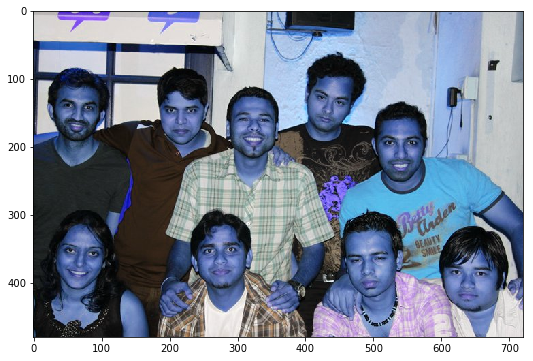

In [26]:
test1 = cv2.imread('faces.jpg')
plt.figure(figsize=(9,6))
plt.imshow(test1,cmap='gray')
plt.show()  

In [71]:
import PIL as Image
import matplotlib.pyplot as plt
def run_face_recognition_image(database):
    """
    Start the face recognition from an Image
    """
    # the face_recognitino library uses keys and values of your database separately
    known_face_encodings = list(database.values())
    known_face_names = list(database.keys())
    pil_im = cv2.imread('faces.jpg')
    col_img = cv2.cvtColor(pil_im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(9,6))
    plt.imshow(col_img)
    plt.show()  
    #convert the test image to gray image as opencv face detector expects gray images 

    frame = col_img.copy()

    # run detection and embedding models
    face_locations, face_encodings = get_face_embeddings_from_image(frame, convert_to_rgb=True)

    # Loop through each face in this frame of video and see if there's a match
    for location, face_encoding in zip(face_locations, face_encodings):

        # get the distances from this encoding to those of all reference images
        distances = face_recognition.face_distance(known_face_encodings, face_encoding)

        # select the closest match (smallest distance) if it's below the threshold value
        if np.any(distances <= MAX_DISTANCE):
            best_match_idx = np.argmin(distances)
            name = known_face_names[best_match_idx]
        else:
            name = None

        # put recognition info on the image
        paint_detected_face_on_image(frame, location, name)
    plt.figure(figsize=(15,12))
    plt.imshow(frame)
    plt.show()  
      


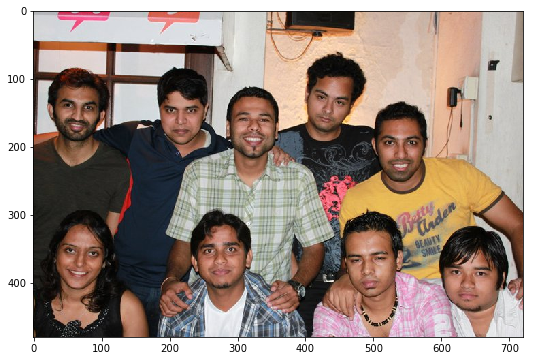

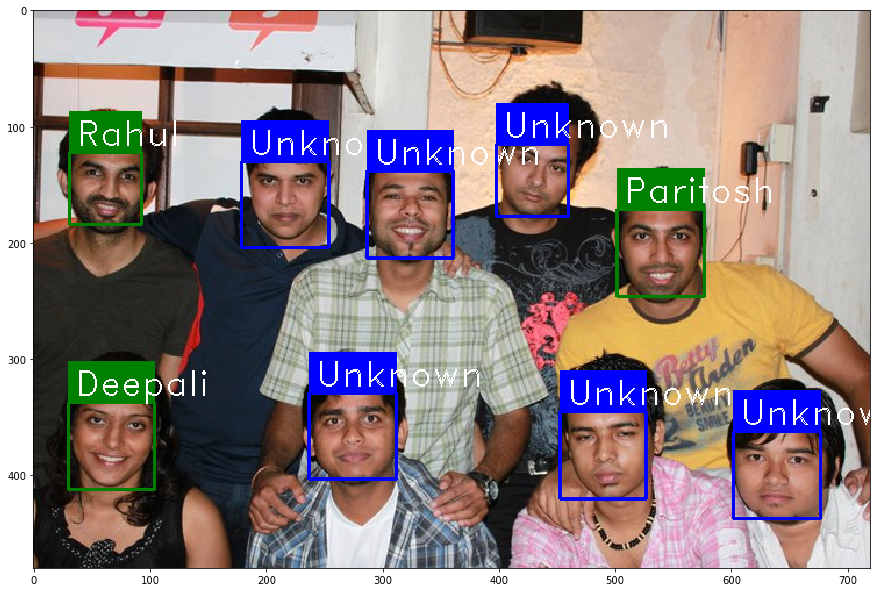

In [73]:
# Required only once
# database = setup_database()

# if you want to load the face encoding from a file instead of processing it at each run, use the function load_database_from_file()
database = load_database_from_file()
run_face_recognition_image(database)

In [75]:
image_rgb = face_recognition.load_image_file('./intranet_images/rahul.jpg')

# use the name in the filename as the identity key
# identity = os.path.splitext(os.path.basename(filename))[0]

# get the face encoding and link it to the identity
locations, encodings = get_face_embeddings_from_image(image_rgb)
encodings_array = np.array(encodings)
encodings_array.shape

(1, 128)